# LPNet concept
Without refinement

## Imports

In [1]:
from PIL import Image
import os
import torch
from torch import nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Loading images

In [2]:
TYPE = 'input'
SET = 'test'

In [3]:
%time
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            images.append(img)
    return images

folder_path = f"D:/SD7K/Shadoc/{SET}/{TYPE}"
loaded_images = load_images_from_folder(folder_path)[:10]

Wall time: 0 ns


In [4]:
print(len(loaded_images))
print(type(loaded_images[0]))
print(loaded_images[0].size)

10
<class 'PIL.PngImagePlugin.PngImageFile'>
(2405, 3705)


In [5]:
transform = transforms.Compose([
    # transforms.Resize((768,1024)),
    transforms.ToTensor(),           # Convert images to tensors
])

In [6]:
# Convert PIL images to tensors
%time
tensor_images = [transform(img) for img in loaded_images]
tensor_images = torch.stack(tensor_images)

Wall time: 0 ns


In [7]:
print(len(tensor_images))
print(type(tensor_images[0]))
print(tensor_images[0].shape)

10
<class 'torch.Tensor'>
torch.Size([3, 3705, 2405])


## Network

In [11]:
class LPNet():
    def __init__(self, L=2, interp_mode='nearest-exact'):
        self.L = L
        self.interp_mode = interp_mode
        pass
    
    def forward(self,I0):
        H = []
        shapes = []
        IL = I0
        for l in range(self.L):
            curr_dim = IL.shape
            shapes.append(curr_dim)

            IL_next = nn.functional.interpolate(IL,size=[curr_dim[2]//2,curr_dim[3]//2],mode=self.interp_mode)
            IL_next_up = nn.functional.interpolate(IL_next,size=[curr_dim[2],curr_dim[3]],mode=self.interp_mode)
            Hl = IL - IL_next_up
            H.append(Hl)

            IL = IL_next
        
        # return IL, H
        '''
        I2IT: inversion
        '''
        IL_cap = []
        for i in range(I0.shape[0]):
            IL_cap.append(transforms.functional.invert(IL[i]))
        IL_cap = torch.stack(IL_cap)

        # I0_cap = IL_cap
        for l in range(self.L-1,-1,-1):
            IL_cap_next_up = nn.functional.interpolate(IL_cap,size=[shapes[l][2],shapes[l][3]],mode=self.interp_mode)
            IL_cap = H[l] + IL_cap_next_up

        return IL_cap
        
    

In [12]:
lp_model = LPNet(L=4)

In [13]:
# IL, H = lp_model.forward(tensor_images[:2])
I0_cap = lp_model.forward(tensor_images[:2])

In [14]:
# n_img=2
# fig, axs = plt.subplots(n_img,lp_model.L,figsize=(10*n_img, 8*(lp_model.L)))

# for i in range(n_img):
#     for l in range(lp_model.L):
#         axs[i][l].set_title(f'{H[l][i].shape[2]}, {H[l][i].shape[1]}')
#         axs[i][l].imshow(np.swapaxes(np.swapaxes(H[l][i],0, 2),0,1))
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


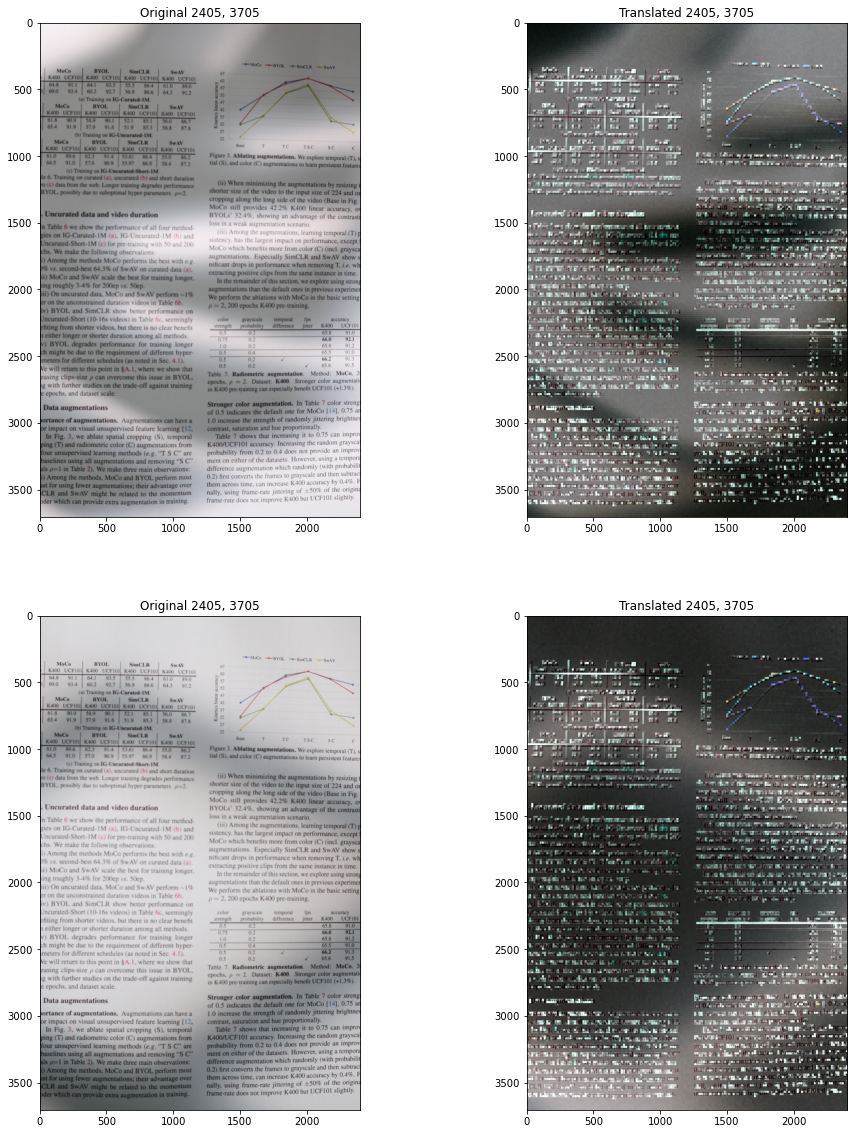

In [15]:
n_img=2
fig, axs = plt.subplots(n_img,2,figsize=(8*2, 10*n_img))

for i in range(n_img):
    axs[i][0].set_title(f'Original {tensor_images[i].shape[2]}, {tensor_images[i].shape[1]}')
    axs[i][0].imshow(np.swapaxes(np.swapaxes(tensor_images[i],0, 2),0,1))

    axs[i][1].set_title(f'Translated {I0_cap[i].shape[2]}, {I0_cap[i].shape[1]}')
    axs[i][1].imshow(np.swapaxes(np.swapaxes(I0_cap[i],0, 2),0,1))
    